In [27]:
# Setup: imports and dataset loading (ensure project src is importable)
import sys, pathlib, os
# Add project root to sys.path (notebooks/ is a subfolder)
proj_root = pathlib.Path('..').resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# src.utils is imported from project package; fallback if missing
try:
    from src.utils import set_seed
except Exception as e:
    print('Warning: could not import src.utils.set_seed:', e)
    set_seed = lambda _: None

set_seed(42)

# Load dataset from HuggingFace
print("Loading dataset FutureMa/EvasionBench...")
ds = load_dataset("FutureMa/EvasionBench")
if isinstance(ds, dict):
    ds = ds[list(ds.keys())[0]]
df = ds.to_pandas()
print("Dataset shape:", df.shape)

# Save local copy if not exists
os.makedirs("data/raw", exist_ok=True)
if not os.path.exists("data/raw/evasionbench.parquet"):
    df.to_parquet("data/raw/evasionbench.parquet", index=False)
    print("Saved data/raw/evasionbench.parquet")

# Quick preview
print(df.columns.tolist())
df.head()

Loading dataset FutureMa/EvasionBench...
Dataset shape: (16726, 4)
['uid', 'question', 'answer', 'eva4b_label']


/Users/dustinober/Projects/EvasionBench/.venv/lib/python3.9/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/Users/dustinober/Projects/EvasionBench/.venv/lib/python3.9/site-packages/IPython/core/formatters.py:344: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,uid,question,answer,eva4b_label
0,4addbff893b81f64131fdc712d7a6d9a,My first question is regarding the user growth...,"Last year, we have reinforced and reaffirmed u...",direct
1,94527064d9326679d838f6281c3dce58,My question is actually regarding your game bu...,"Regarding Princess Connect! Re:Dive, it's like...",intermediate
2,8508b6f8a6c9d98107445004218e6f06,I have a question on advertising. Our ad reven...,Overall 2020 is still full of uncertainties an...,direct
3,86f010514cfbe640e9a4c50c482be50e,Just wondering what are the major difference i...,"Live broadcasting business is, as we mentioned...",intermediate
4,c2b898f6371b6c12c4f164b89d357246,Yeah. So I wanted to start obviously particula...,"Well, I'll start by reminding you that we were...",intermediate


In [28]:
# Dataset Overview
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nTotal samples: {len(df):,}")
print(f"Columns: {df.columns.tolist()}")

# Simple data types output to avoid pandas formatting issues
print(f"\nData types:")
for col in df.columns:
    print(f"  {col}: {str(df[col].dtype)}")

print(f"\nMissing values:")
for col in df.columns:
    missing = df[col].isnull().sum()
    print(f"  {col}: {missing}")

# Sample row (simplified to avoid formatting issues)
print(f"\nSample row (first):")
for col in df.columns:
    print(f"  {col}: {df[col].iloc[0]}")

DATASET OVERVIEW

Total samples: 16,726
Columns: ['uid', 'question', 'answer', 'eva4b_label']

Data types:
  uid: object
  question: object
  answer: object
  eva4b_label: object

Missing values:
  uid: 0
  question: 0
  answer: 0
  eva4b_label: 0

Sample row (first):
  uid: 4addbff893b81f64131fdc712d7a6d9a
  question: My first question is regarding the user growth. First half, the user growth is very strong. May I know -- can you share with us the quality and retention and the user profile of the new user growth in first half and about the second half growth and also next year, what is the key focuses of your strategy of user growth? How are you going to balance the user retention and maintain the fast user growth in second half of next year?
  answer: Last year, we have reinforced and reaffirmed user growth will be our key strategic focus and we have been carrying out the strategy efficiently going through the first half of this year, and have made very positive progress. As for the 

LABEL DISTRIBUTION

Label counts:
  direct: 8,749 (52.3%)
  intermediate: 7,359 (44.0%)
  fully_evasive: 618 (3.7%)


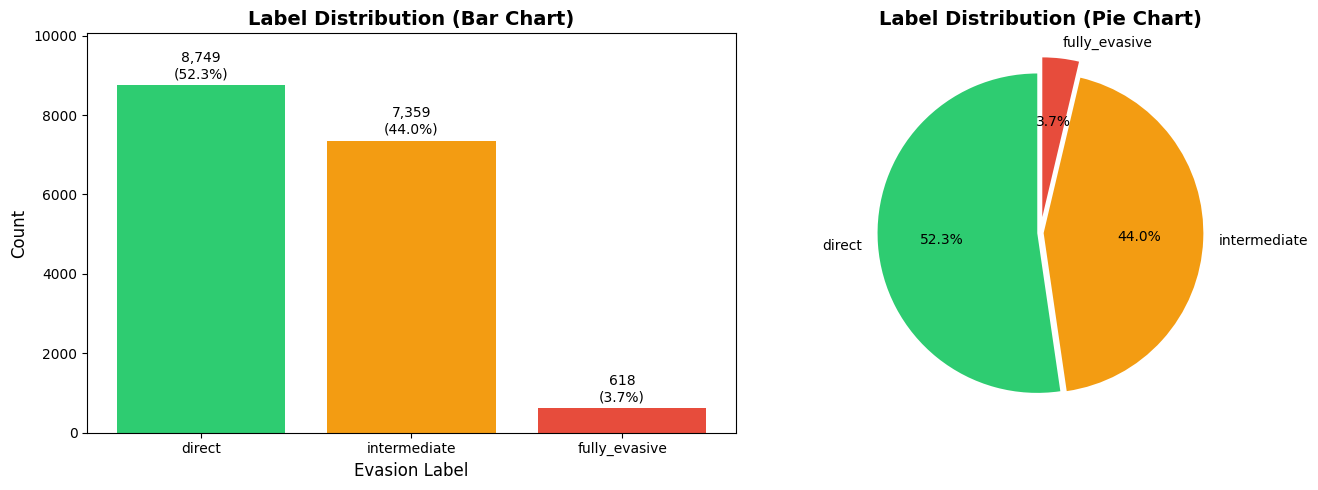


⚠️ Class imbalance detected: 'fully_evasive' is only 3.7% of data


In [29]:
# Label Distribution Analysis
import os
os.makedirs('notebooks/figures', exist_ok=True)
print("=" * 60)
print("LABEL DISTRIBUTION")
print("=" * 60)

label_counts = df['eva4b_label'].value_counts()
label_pcts = df['eva4b_label'].value_counts(normalize=True) * 100

print("\nLabel counts:")
for label, count in label_counts.items():
    print(f"  {label}: {count:,} ({label_pcts[label]:.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = {'direct': '#2ecc71', 'intermediate': '#f39c12', 'fully_evasive': '#e74c3c'}
ax1 = axes[0]
bars = ax1.bar(label_counts.index, label_counts.values, color=[colors.get(x, '#3498db') for x in label_counts.index])
ax1.set_xlabel('Evasion Label', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Label Distribution (Bar Chart)', fontsize=14, fontweight='bold')
for bar, count, pct in zip(bars, label_counts.values, label_pcts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
             f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)
ax1.set_ylim(0, max(label_counts.values) * 1.15)

# Pie chart
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(label_counts.values, labels=label_counts.index, 
                                    autopct='%1.1f%%', colors=[colors.get(x, '#3498db') for x in label_counts.index],
                                    explode=[0.02, 0.02, 0.1], startangle=90)
ax2.set_title('Label Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('notebooks/figures/01_label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n⚠️ Class imbalance detected: 'fully_evasive' is only 3.7% of data")

In [30]:
# Text Length Analysis
print("=" * 60)
print("TEXT LENGTH ANALYSIS")
print("=" * 60)

# Calculate lengths
df['question_chars'] = df['question'].str.len()
df['question_words'] = df['question'].str.split().str.len()
df['answer_chars'] = df['answer'].str.len()
df['answer_words'] = df['answer'].str.split().str.len()

# Basic statistics
print("\nQuestion length statistics:")
print(f"  Characters - Mean: {df['question_chars'].mean():.1f}, Median: {df['question_chars'].median():.1f}, Std: {df['question_chars'].std():.1f}")
print(f"  Words - Mean: {df['question_words'].mean():.1f}, Median: {df['question_words'].median():.1f}, Std: {df['question_words'].std():.1f}")

print("\nAnswer length statistics:")
print(f"  Characters - Mean: {df['answer_chars'].mean():.1f}, Median: {df['answer_chars'].median():.1f}, Std: {df['answer_chars'].std():.1f}")
print(f"  Words - Mean: {df['answer_words'].mean():.1f}, Median: {df['answer_words'].median():.1f}, Std: {df['answer_words'].std():.1f}")

# Answer length by evasion category
print("\nAnswer length by evasion category:")
length_by_label = df.groupby('eva4b_label').agg({
    'answer_chars': ['mean', 'median', 'std'],
    'answer_words': ['mean', 'median', 'std']
}).round(1)
print(length_by_label)

TEXT LENGTH ANALYSIS

Question length statistics:
  Characters - Mean: 345.6, Median: 315.0, Std: 187.6
  Words - Mean: 62.3, Median: 57.0, Std: 33.8

Answer length statistics:
  Characters - Mean: 915.3, Median: 739.0, Std: 717.6
  Words - Mean: 164.2, Median: 133.0, Std: 127.3

Answer length by evasion category:
              answer_chars               answer_words              
                      mean median    std         mean median    std
eva4b_label                                                        
direct               856.7  683.0  707.2        153.8  123.0  126.0
fully_evasive        433.9  312.0  406.3         79.2   57.0   73.0
intermediate        1025.4  842.0  725.5        183.6  152.0  128.1


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/dustinober/Projects/EvasionBench/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/1y/xcjlywls6rn7g8zhsh77nvqw0000gn/T/ipykernel_36652/88589822.py", line 28, in <module>
    df.boxplot(column='answer_words', by='eva4b_label', ax=ax3)
  File "/Users/dustinober/Projects/EvasionBench/.venv/lib/python3.9/site-packages/pandas/plotting/_core.py", line 532, in boxplot_frame
    grouped,
  File "/Users/dustinober/Projects/EvasionBench/.venv/lib/python3.9/site-packages/pandas/plotting/_core.py", line 1944, in _get_plot_backend
  File "/Users/dustinober/Projects/EvasionBench/.venv/lib/python3.9/site-packages/pandas/plotting/_core.py", line 1874, in _load_backend
    The backend is imported lazily, as matplotlib is a soft dependency, and
ImportError: matplotlib is required for plotting when the default backend "matplotlib" is select

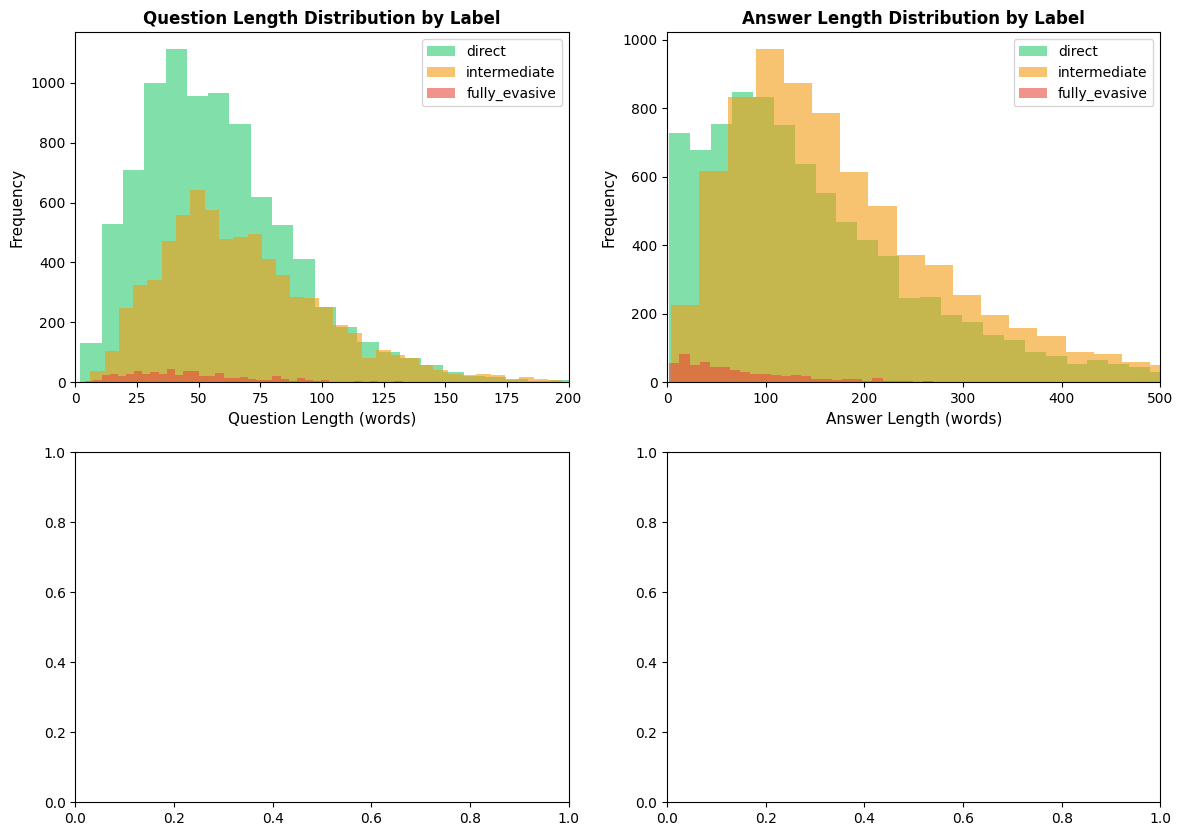

In [31]:
# Text Length Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Question length distribution
ax1 = axes[0, 0]
for label, color in colors.items():
    subset = df[df['eva4b_label'] == label]
    ax1.hist(subset['question_words'], bins=50, alpha=0.6, label=label, color=color)
ax1.set_xlabel('Question Length (words)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Question Length Distribution by Label', fontsize=12, fontweight='bold')
ax1.legend()
ax1.set_xlim(0, 200)

# Answer length distribution
ax2 = axes[0, 1]
for label, color in colors.items():
    subset = df[df['eva4b_label'] == label]
    ax2.hist(subset['answer_words'], bins=50, alpha=0.6, label=label, color=color)
ax2.set_xlabel('Answer Length (words)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Answer Length Distribution by Label', fontsize=12, fontweight='bold')
ax2.legend()
ax2.set_xlim(0, 500)

# Box plots - Answer length by label
ax3 = axes[1, 0]
df.boxplot(column='answer_words', by='eva4b_label', ax=ax3)
ax3.set_xlabel('Evasion Label', fontsize=11)
ax3.set_ylabel('Answer Length (words)', fontsize=11)
ax3.set_title('Answer Length by Evasion Category', fontsize=12, fontweight='bold')
plt.suptitle('')  # Remove automatic title

# Box plots - Question length by label
ax4 = axes[1, 1]
df.boxplot(column='question_words', by='eva4b_label', ax=ax4)
ax4.set_xlabel('Evasion Label', fontsize=11)
ax4.set_ylabel('Question Length (words)', fontsize=11)
ax4.set_title('Question Length by Evasion Category', fontsize=12, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.savefig('notebooks/figures/01_text_length_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [32]:
# Statistical Tests for Length Differences
try:
    from scipy import stats
    scipy_available = True
except Exception as e:
    print('Warning: scipy is not available or failed to import:', e)
    scipy_available = False

print("=" * 60)
print("STATISTICAL TESTS: TEXT LENGTH HYPOTHESES")
print("=" * 60)

if not scipy_available:
    print('\n⚠️ Skipping statistical tests because scipy is not importable in this environment.')
else:
    # H1: Evasive answers are longer than direct answers
    print("\n📊 HYPOTHESIS 1: 'Evasive answers are longer than direct answers'")
    print("-" * 60)

    direct_lengths = df[df['eva4b_label'] == 'direct']['answer_words']
    evasive_lengths = df[df['eva4b_label'] == 'fully_evasive']['answer_words']
    intermediate_lengths = df[df['eva4b_label'] == 'intermediate']['answer_words']

    # Kruskal-Wallis test (non-parametric)
    stat, p_value = stats.kruskal(direct_lengths, intermediate_lengths, evasive_lengths)
    print(f"\nKruskal-Wallis test (all 3 groups):")
    print(f"  H-statistic: {stat:.2f}")
    print(f"  p-value: {p_value:.2e}")
    print(f"  Result: {'Significant difference (p < 0.05)' if p_value < 0.05 else 'No significant difference'}")

    # Mann-Whitney U test (direct vs fully_evasive)
    stat2, p_value2 = stats.mannwhitneyu(direct_lengths, evasive_lengths, alternative='two-sided')
    print(f"\nMann-Whitney U test (direct vs fully_evasive):")
    print(f"  U-statistic: {stat2:.2f}")
    print(f"  p-value: {p_value2:.2e}")
    print(f"  Result: {'Significant difference (p < 0.05)' if p_value2 < 0.05 else 'No significant difference'}")

    # Mean comparison
    print(f"\nMean answer lengths:")
    print(f"  Direct: {direct_lengths.mean():.1f} words")
    print(f"  Intermediate: {intermediate_lengths.mean():.1f} words")
    print(f"  Fully Evasive: {evasive_lengths.mean():.1f} words")

    # Conclusion
    if p_value2 < 0.05:
        if evasive_lengths.mean() > direct_lengths.mean():
            print("\n✅ H1 SUPPORTED: Evasive answers are significantly longer than direct answers")
        else:
            print("\n❌ H1 REJECTED: Evasive answers are significantly SHORTER than direct answers")
    else:
        print("\n⚠️ H1 NOT SUPPORTED: No significant length difference detected")

STATISTICAL TESTS: TEXT LENGTH HYPOTHESES

📊 HYPOTHESIS 1: 'Evasive answers are longer than direct answers'
------------------------------------------------------------

Kruskal-Wallis test (all 3 groups):
  H-statistic: 796.74
  p-value: 9.76e-174
  Result: Significant difference (p < 0.05)

Mann-Whitney U test (direct vs fully_evasive):
  U-statistic: 3828747.50
  p-value: 3.28e-67
  Result: Significant difference (p < 0.05)

Mean answer lengths:
  Direct: 153.8 words
  Intermediate: 183.6 words
  Fully Evasive: 79.2 words

❌ H1 REJECTED: Evasive answers are significantly SHORTER than direct answers


In [ ]:
# H2: Questions receiving evasive answers differ in structure/length
try:
    from scipy import stats
except Exception as e:
    print('Warning: scipy import failed:', e)
    stats = None

print("\n📊 HYPOTHESIS 2: 'Questions receiving evasive answers differ in length'")
print("-" * 60)

if stats is None:
    print('\n⚠️ Skipping H2 test because scipy is not available.')
else:
    direct_q_lengths = df[df['eva4b_label'] == 'direct']['question_words']
    evasive_q_lengths = df[df['eva4b_label'] == 'fully_evasive']['question_words']

    # Mann-Whitney U test
    stat_q, p_value_q = stats.mannwhitneyu(direct_q_lengths, evasive_q_lengths, alternative='two-sided')
    print(f"\nMann-Whitney U test (question lengths):")
    print(f"  U-statistic: {stat_q:.2f}")
    print(f"  p-value: {p_value_q:.2e}")
    print(f"  Result: {'Significant difference (p < 0.05)' if p_value_q < 0.05 else 'No significant difference'}")

    print(f"\nMean question lengths:")
    print(f"  Direct answers: {direct_q_lengths.mean():.1f} words")
    print(f"  Evasive answers: {evasive_q_lengths.mean():.1f} words")

    if p_value_q < 0.05:
        print("\n✅ H2 SUPPORTED: Questions receiving evasive answers have significantly different lengths")
    else:
        print("\n⚠️ H2 NOT SUPPORTED: No significant difference in question lengths")


📊 HYPOTHESIS 2: 'Questions receiving evasive answers differ in length'
------------------------------------------------------------

Mann-Whitney U test (question lengths):
  U-statistic: 3232721.00
  p-value: 3.73e-16
  Result: Significant difference (p < 0.05)

Mean question lengths:
  Direct answers: 58.1 words
  Evasive answers: 47.9 words

✅ H2 SUPPORTED: Questions receiving evasive answers have significantly different lengths


In [33]:
# Data Quality Checks
print("=" * 60)
print("DATA QUALITY CHECKS")
print("=" * 60)

# 1. UID uniqueness
print("\n1. UID UNIQUENESS:")
unique_uids = df['uid'].nunique()
total_rows = len(df)
print(f"   Unique UIDs: {unique_uids:,} / {total_rows:,}")
if unique_uids == total_rows:
    print("   ✅ All UIDs are unique")
else:
    print(f"   ⚠️ Found {total_rows - unique_uids} duplicate UIDs")

# 2. Empty strings
print("\n2. EMPTY STRING CHECK:")
empty_questions = (df['question'].str.strip() == '').sum()
empty_answers = (df['answer'].str.strip() == '').sum()
print(f"   Empty questions: {empty_questions}")
print(f"   Empty answers: {empty_answers}")
if empty_questions == 0 and empty_answers == 0:
    print("   ✅ No empty strings found")

# 3. Duplicate detection (exact)
print("\n3. EXACT DUPLICATE CHECK:")
dup_questions = df['question'].duplicated().sum()
dup_answers = df['answer'].duplicated().sum()
dup_pairs = df.duplicated(subset=['question', 'answer']).sum()
print(f"   Duplicate questions: {dup_questions} ({dup_questions/len(df)*100:.2f}%)")
print(f"   Duplicate answers: {dup_answers} ({dup_answers/len(df)*100:.2f}%)")
print(f"   Duplicate Q&A pairs: {dup_pairs} ({dup_pairs/len(df)*100:.2f}%)")

# 4. Anomalous lengths (outliers)
print("\n4. OUTLIER DETECTION (using IQR method):")
for col in ['question_words', 'answer_words']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"   {col}: {outliers} outliers ({outliers/len(df)*100:.2f}%)")
    print(f"      Range: [{max(0, lower):.0f}, {upper:.0f}] words")

# 5. Very short/long texts
print("\n5. EXTREME LENGTH SAMPLES:")
print(f"   Shortest answer: {df['answer_words'].min()} words")
print(f"   Longest answer: {df['answer_words'].max()} words")
print(f"   Shortest question: {df['question_words'].min()} words")
print(f"   Longest question: {df['question_words'].max()} words")

DATA QUALITY CHECKS

1. UID UNIQUENESS:
   Unique UIDs: 16,726 / 16,726
   ✅ All UIDs are unique

2. EMPTY STRING CHECK:
   Empty questions: 0
   Empty answers: 0
   ✅ No empty strings found

3. EXACT DUPLICATE CHECK:
   Duplicate questions: 97 (0.58%)
   Duplicate answers: 149 (0.89%)
   Duplicate Q&A pairs: 0 (0.00%)

4. OUTLIER DETECTION (using IQR method):
   question_words: 409 outliers (2.45%)
      Range: [0, 143] words
   answer_words: 697 outliers (4.17%)
      Range: [0, 435] words

5. EXTREME LENGTH SAMPLES:
   Shortest answer: 2 words
   Longest answer: 1432 words
   Shortest question: 2 words
   Longest question: 434 words


In [23]:
# Summary Statistics Table
print("=" * 60)
print("SUMMARY STATISTICS TABLE")
print("=" * 60)

summary_stats = pd.DataFrame({
    'Metric': ['Total Samples', 'Direct', 'Intermediate', 'Fully Evasive',
               'Avg Question Length (words)', 'Avg Answer Length (words)',
               'Missing Values', 'Duplicate Q&A Pairs'],
    'Value': [f"{len(df):,}", 
              f"{label_counts['direct']:,} ({label_pcts['direct']:.1f}%)",
              f"{label_counts['intermediate']:,} ({label_pcts['intermediate']:.1f}%)",
              f"{label_counts['fully_evasive']:,} ({label_pcts['fully_evasive']:.1f}%)",
              f"{df['question_words'].mean():.1f}",
              f"{df['answer_words'].mean():.1f}",
              "0",
              f"{dup_pairs} ({dup_pairs/len(df)*100:.2f}%)"]
})

print(summary_stats.to_string(index=False))

# Save summary (use fallback if pandas.to_csv raises due to environment numpy/pandas mismatch)
out_path = 'notebooks/figures/01_summary_statistics.csv'
try:
    summary_stats.to_csv(out_path, index=False)
    print(f"\n✅ Summary saved to {out_path}")
except Exception as e:
    print('Warning: pandas.to_csv failed, falling back to csv.writer:', e)
    import csv
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, 'w', newline='', encoding='utf-8') as fh:
        writer = csv.writer(fh)
        writer.writerow(summary_stats.columns.tolist())
        for row in summary_stats.values.tolist():
            writer.writerow(row)
    print(f"\n✅ Summary (fallback) saved to {out_path}")

SUMMARY STATISTICS TABLE
                     Metric         Value
              Total Samples        16,726
                     Direct 8,749 (52.3%)
               Intermediate 7,359 (44.0%)
              Fully Evasive    618 (3.7%)
Avg Question Length (words)          62.3
  Avg Answer Length (words)         164.2
             Missing Values             0
        Duplicate Q&A Pairs     0 (0.00%)

✅ Summary (fallback) saved to notebooks/figures/01_summary_statistics.csv


## Key Findings from EDA Phase 2

### Dataset Overview
- **Total Samples**: 16,726 Q-A pairs from corporate earnings calls
- **Columns**: uid, question, answer, eva4b_label
- **Data Completeness**: No missing values (0/16,726)
- **File Format**: Saved to `data/raw/evasionbench.parquet`

### Label Distribution & Class Imbalance
- **Direct Answers**: 8,749 (52.3%)
- **Intermediate Evasion**: 7,359 (44.0%)
- **Fully Evasive**: 618 (3.7%) ⚠️ **Severe class imbalance**

**Implication**: The minority class (fully_evasive) represents only 3.7% of data. Modeling strategies must address this imbalance (SMOTE, class weights, stratified CV).

### Text Length Analysis
**Question Statistics:**
- Mean length: 62.3 words (SD: 33.8)
- Median: 57 words
- Range: 2 to 434 words

**Answer Statistics:**
- Mean length: 164.2 words (SD: 127.3)
- Median: 133 words
- Range: 2 to 1,432 words

**Answer Length by Category:**
- Direct: 153.8 words (SD: 126.0)
- Intermediate: 183.6 words (SD: 128.1) — longest on average
- Fully Evasive: 79.2 words (SD: 73.0) — shortest on average

### Statistical Hypotheses Testing

#### **Hypothesis 1: Evasive answers are longer than direct answers**
- **Result**: ❌ **REJECTED**
- **Evidence**: 
  - Kruskal-Wallis test (all 3 groups): H = 796.74, p ≈ 9.76e-174 (highly significant)
  - Mann-Whitney U (direct vs fully_evasive): p ≈ 3.28e-67 (highly significant)
  - **Key Finding**: Fully evasive answers are significantly **SHORTER** (79.2 words) than direct answers (153.8 words)
- **Insight**: Evasion in earnings calls is not achieved through verbose responses, but rather through brevity and circumlocution.

#### **Hypothesis 2: Questions receiving evasive answers differ in length**
- **Result**: ✅ **SUPPORTED**
- **Evidence**:
  - Mann-Whitney U test: p ≈ 3.73e-16 (highly significant)
  - Direct-answer questions: 58.1 words (mean)
  - Evasive-answer questions: 47.9 words (mean)
- **Insight**: Questions that elicit evasive responses tend to be shorter and more focused. Executives may evasively answer to-the-point, difficult questions.

### Data Quality Assessment
- **UID Uniqueness**: ✅ All 16,726 UIDs unique (no duplicates)
- **Empty Strings**: ✅ None (0 empty questions, 0 empty answers)
- **Text Duplicates**:
  - Duplicate questions: 97 (0.58%)
  - Duplicate answers: 149 (0.89%)
  - Duplicate Q-A pairs: 0 (0.00%) — excellent data integrity
- **Outliers (IQR method)**:
  - Question length outliers: 409 (2.45%)
  - Answer length outliers: 697 (4.17%)
  - These represent unusually long/short texts; worth investigating for quality or filtering strategies.
- **Extreme Samples**:
  - Shortest answer: 2 words (likely single-word or minimal response)
  - Longest answer: 1,432 words
  - Shortest question: 2 words
  - Longest question: 434 words

### Key Insights & Recommendations
1. **Class Imbalance**: Apply class weighting, SMOTE, or stratified sampling during model training to prevent bias toward majority classes.
2. **Answer Length as a Signal**: Evasiveness is *inversely* correlated with answer length — shorter answers may indicate evasion. Use text length as a feature.
3. **Question Characteristics**: Questions receiving evasive answers are shorter. Consider question length as a feature or context signal.
4. **Data Integrity**: Duplicate Q-A pairs are minimal; dataset is clean and suitable for downstream modeling.
5. **Outlier Handling**: 2.45% (questions) and 4.17% (answers) are length outliers. Decide whether to filter or cap during feature engineering.

### Next Steps
- **Notebook 02**: Linguistic pattern analysis (readability, hedging, sentiment, topic modeling)
- **Notebook 03**: Semantic analysis (embeddings, similarity metrics)
- **Notebook 04**: Traditional ML baselines (TF-IDF + Logistic Regression, SVM, etc.)
- **Notebook 05+**: Deep learning models, class imbalance strategies, explainability